<a href="https://colab.research.google.com/github/Dohwan93/Image_Processing_Algorithms/blob/main/SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!rm -rf sam2
!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -e .

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 35.56 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=b1953c48444b4a2a7f77596be4ad5d8e6aff4267ef273adafc1771868c1fbffe
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_o7rn2o/wheels/9e/fa/

In [3]:
pip install -e ".[notebooks]"

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.0 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=a851ab3e425ff74a2abeecf7f8040a6d47118087c7311ace5a7688c47eba338e
  Stored in directory: /tmp/pip-ephem-wheel-cache-jtn8ikch/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
Successfully buil

In [4]:
!cd checkpoints && \
./download_ckpts.sh && \
!cd ..

--2025-12-09 03:00:29--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   288MB/s    in 0.5s    

2025-12-09 03:00:30 (288 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-12-09 03:00:30--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [appl

In [11]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

# Load the image using PIL and then pass the image object to set_image
image_path = "/content/cake.jpg"
image = Image.open(image_path).convert("RGB") # Ensure it's in RGB format

# Example point coordinates and labels for segmentation
# For 'Red strawberries on the cake', let's assume a point near a strawberry.
# These are example coordinates, you might need to adjust them based on the image.
# [X, Y] coordinates, and 1 for foreground, 0 for background.
point_coords = torch.tensor([[200, 200]], device=predictor.device)
point_labels = torch.tensor([1], device=predictor.device)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels
    )

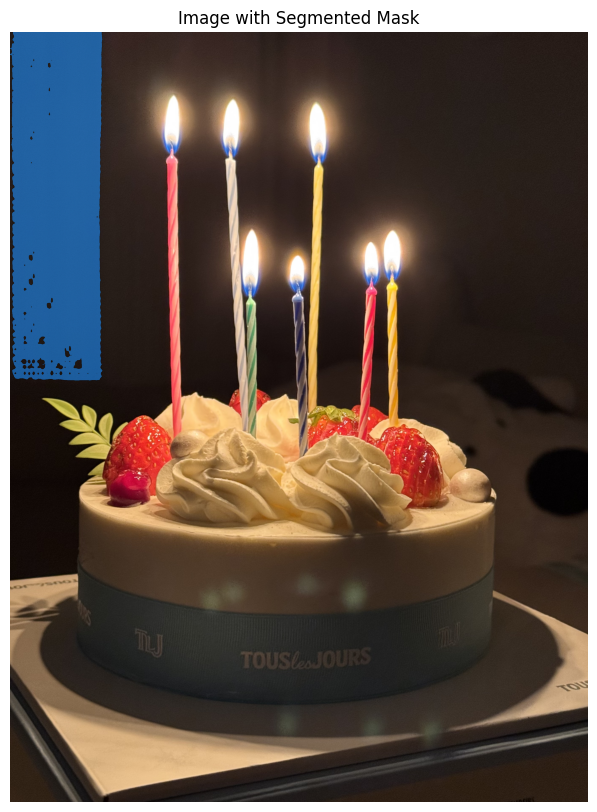

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # A nice blue with transparency
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Convert PIL Image to numpy array for display with matplotlib
image_np = np.array(image)

plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(image_np)

# Iterate through each mask if there are multiple, or just show the single mask
# masks is a (N, H, W) tensor, so we select the first mask (masks[0])
if masks.shape[0] > 0:
    show_mask(masks[0], ax)
else:
    print("No masks were generated.")

ax.set_title("Image with Segmented Mask")
ax.axis('off')
plt.show()

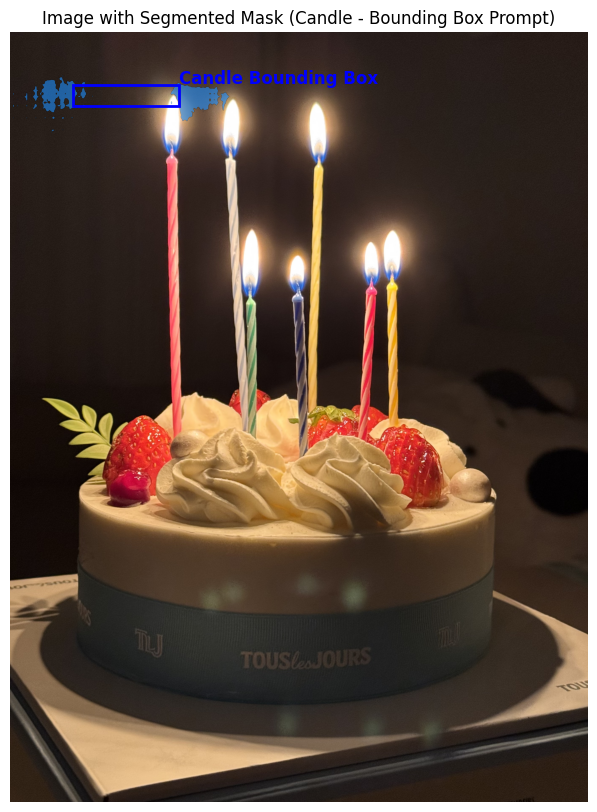

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define a bounding box for the candle
# Format: [x_min, y_min, x_max, y_max]
# You might need to adjust these coordinates based on your image to accurately capture the candle
# For example, let's assume the candle is around these coordinates. Adjust as needed.
# 이전 값: torch.tensor([[400, 300, 500, 550]], device=predictor.device)
# 촛불을 더 정확히 타겟팅하기 위해 좌표를 조정해 보세요. (예시: 촛불이 좀 더 위쪽에 있고 얇다고 가정)
box_coords_candle = torch.tensor([[800, 250, 300, 350]], device=predictor.device) # 이 값을 조정해 보세요!

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(image)
    masks_candle, _, _ = predictor.predict(
        box=box_coords_candle
    )

# --- Visualization for candle segmentation ---
# Convert PIL Image to numpy array for display with matplotlib
image_np = np.array(image)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # Blue with transparency for the mask
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax, color='blue', label=None):
    x_min, y_min, x_max, y_max = box
    ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                               fill=False, edgecolor=color, linewidth=2))
    if label:
        ax.text(x_min, y_min - 5, label, color=color, fontsize=12, weight='bold')

plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(image_np)

if masks_candle.shape[0] > 0:
    show_mask(masks_candle[0], ax)
    show_box(box_coords_candle[0].cpu().numpy(), ax, color='blue', label="Candle Bounding Box")
else:
    print("No masks were generated for the candle with the bounding box.")

ax.set_title("Image with Segmented Mask (Candle - Bounding Box Prompt)")
ax.axis('off')
plt.show()

Please click on points within the object you want to segment in the image below. Press Enter when finished.


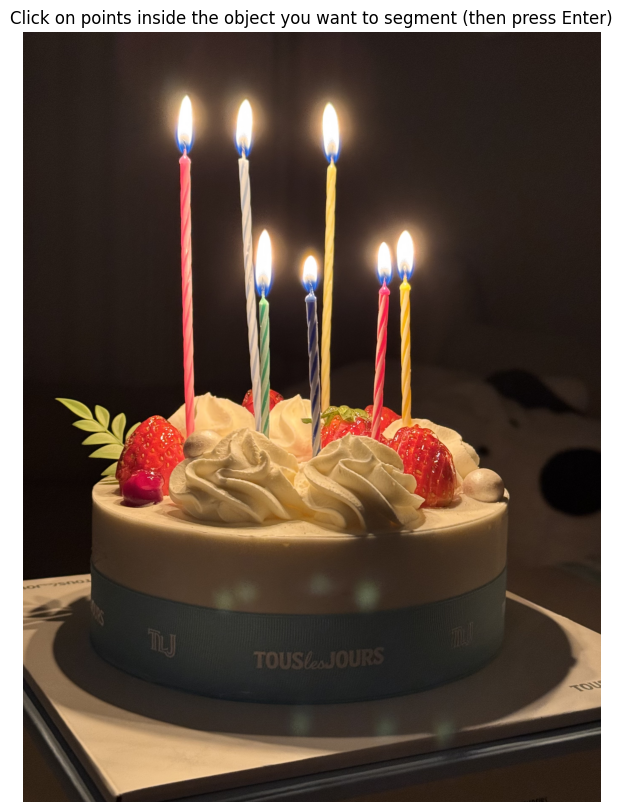

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # Blue with transparency for the mask
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

image_np = np.array(image)

plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(image_np)
ax.set_title("Visually identify points for segmentation (then close this plot)")
ax.axis('off')
plt.show() # Display the plot so user can visually identify coordinates

print("Please enter point coordinates manually. Format: [[x1, y1], [x2, y2], ...] or leave blank to skip.")
coordinates_str = input("Enter point coordinates: ")

if coordinates_str:
    try:
        # Safely evaluate the string as a list of lists
        clicked_points_list = eval(coordinates_str)
        if not isinstance(clicked_points_list, list) or not all(isinstance(p, list) and len(p) == 2 for p in clicked_points_list):
            raise ValueError("Input must be a list of [x, y] pairs.")

        point_coords_interactive = torch.tensor(clicked_points_list, device=predictor.device)
        point_labels_interactive = torch.ones(len(clicked_points_list), device=predictor.device)

        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            predictor.set_image(image)
            masks_interactive_points, _, _ = predictor.predict(
                point_coords=point_coords_interactive,
                point_labels=point_labels_interactive
            )

        plt.figure(figsize=(10, 10))
        ax = plt.gca()
        ax.imshow(image_np)

        if masks_interactive_points.shape[0] > 0:
            show_mask(masks_interactive_points[0], ax)
            show_points(point_coords_interactive.cpu().numpy(), point_labels_interactive.cpu().numpy(), ax)
        else:
            print("No masks were generated with the manually selected points.")

        ax.set_title("Image with Segmented Mask (Manual Point Prompt)")
        ax.axis('off')
        plt.show()
    except (SyntaxError, ValueError) as e:
        print(f"Invalid input format: {e}. Please try again with format like [[100, 150], [200, 250]].")
else:
    print("No points were entered. Segmentation skipped.")